# Loopless FBA

The goal of this procedure is identification of a thermodynamically consistent flux state without loops, as implied by the name. You can find a more detailed description in the [method](#Method) section at the end of the notebook.

In [1]:
%matplotlib inline
import plot_helper

import cobra.test
from cobra import Reaction, Metabolite, Model
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import optimize_minimal_flux

/home/moritz/.virtualenvs/cobra/lib/python3.5/site-packages/optlang/gurobi_interface.py:26: UserWarning: Be careful! The GUROBI interface is still under construction ...
  warn("Be careful! The GUROBI interface is still under construction ...")


We will demonstrate with a toy model which has a simple loop cycling A $\rightarrow$ B $\rightarrow$ C $\rightarrow$ A, with A allowed to enter the system and C allowed to leave. A graphical view of the system is drawn below:

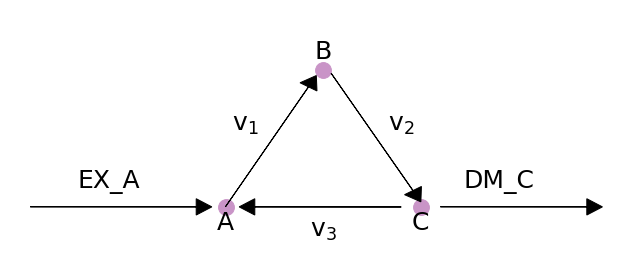

In [2]:
plot_helper.plot_loop()

## Loopless model

In [3]:
model = Model()
model.add_metabolites([Metabolite(i) for i in "ABC"])
model.add_reactions([Reaction(i) for i in ["EX_A", "DM_C", "v1", "v2", "v3"]])

model.reactions.EX_A.add_metabolites({"A": 1})
model.reactions.DM_C.add_metabolites({"C": -1})

model.reactions.v1.add_metabolites({"A": -1, "B": 1})
model.reactions.v2.add_metabolites({"B": -1, "C": 1})
model.reactions.v3.add_metabolites({"C": -1, "A": 1})

model.objective = 'DM_C'

While this model contains a loop, a flux state exists which has no flux through reaction v$_3$, and is identified by loopless FBA.

In [4]:
with model:
    add_loopless(model)
    solution = model.optimize()
print("loopless solution: status = " + solution.status)
print("loopless solution flux: v3 = %.1f" % solution.fluxes["v3"])

loopless solution: status = optimal
loopless solution flux: v3 = 0.0


If there is no forced flux through a loopless reaction, parsimonious FBA will also have no flux through the loop.

In [5]:
solution = optimize_minimal_flux(model)
print("parsimonious solution: status = " + solution.status)
print("loopless solution flux: v3 = %.1f" % solution.fluxes["v3"])

parsimonious solution: status = optimal
loopless solution flux: v3 = 0.0


However, if flux is forced through v$_3$, then there is no longer a feasible loopless solution, but the parsimonious solution will still exist.

In [6]:
model.reactions.v3.lower_bound = 1
with model:
    add_loopless(model)
    try:
        solution = model.optimize()
    except:
        print('model is infeasible')

cobra/util/solver.py:395 UserWarning: solver status is 'infeasible'


In [7]:
solution = optimize_minimal_flux(model)
print("parsimonious solution: status = " + solution.status)
print("loopless solution flux: v3 = %.1f" % solution.fluxes["v3"])

parsimonious solution: status = optimal
loopless solution flux: v3 = 1.0


## Loopless solution

The loopless model described above is computationally expensive to solve. A much faster, and pragmatic approach is instead to post-process flux distributions to simply set fluxes to zero wherever they can be zero without changing the fluxes of any exchange reactions in the model. [CycleFreeFlux](http://dx.doi.org/10.1093/bioinformatics/btv096) is an algorithm that can be used to achieve this and in cobrapy it is implemented in the `cobra.flux_analysis.loopless_solution` function. Using a larger model than the simple example above, this can be demonstrated as follows

In [8]:
salmonella = cobra.test.create_test_model('salmonella')
nominal = salmonella.optimize()
loopless = loopless_solution(salmonella)

In [9]:
import pandas
df = pandas.DataFrame(dict(loopless=loopless, nominal=nominal.fluxes))

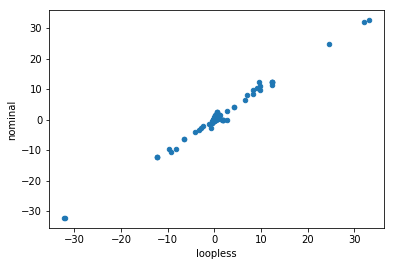

In [10]:
df.plot.scatter(x='loopless', y='nominal')

This functionality can also be used in FVA by using the `loopless=True` argument to avoid getting high flux ranges for reactions that essentially only can reach high fluxes if they are allowed to participate in loops (see the simulation notebook).

## Method

Usually, the model has the following constraints.
$$ S \cdot v = 0 $$
$$ lb \le v \le ub $$

However, this will allow for thermodynamically infeasible loops (referred to as type 3 loops) to occur, where flux flows around a cycle without any net change of metabolites. For most cases, this is not a major issue, as solutions with these loops can usually be converted to equivalent solutions without them. However, if a flux state is desired which does not exhibit any of these loops, loopless FBA can be used. The formulation used here is modified from [Schellenberger et al.](http://dx.doi.org/10.1016/j.bpj.2010.12.3707)

We can make the model irreversible, so that all reactions will satisfy
$$ 0 \le lb \le v \le ub \le \max(ub) $$

We will add in boolean indicators as well, such that
$$ \max(ub) \cdot i \ge v $$
$$ i \in \{0, 1\} $$

We also want to ensure that an entry in the row space of S also exists with negative values wherever v is nonzero. In this expression, $1-i$ acts as a not to indicate inactivity of a reaction.

$$ S^\mathsf T x - (1 - i) (\max(ub) + 1) \le -1 $$

We will construct an LP integrating both constraints.

$$ \left(
\begin{matrix}
S & 0 & 0\\
-I & \max(ub)I & 0 \\
0 & (\max(ub) + 1)I & S^\mathsf T
\end{matrix}
\right)
\cdot
\left(
\begin{matrix}
v \\
i \\
x
\end{matrix}
\right)
\begin{matrix}
&=& 0 \\
&\ge& 0 \\
&\le& \max(ub)
\end{matrix}$$

Note that these extra constraints are not applied to boundary reactions which bring metabolites in and out of the system.